In [33]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# import tensorflow as tf

# mpl.rcParams['figure.figsize'] = (8, 6)
# mpl.rcParams['axes.grid'] = False


Plan:
 - Load sets
 - Clean:
    - remove duplicate entries from sets
    - Drop the unimportant coloumns that we found
    - Make querters into hours
    - remove values from train_targets that are nan in both x and y sets
    - make time features
    - drop datetime coloumns
 - Set prep:
    - 75/25 fordeling. 75% av OBSERVED er trening, resterende 25% er validation, 75% av ESTIMATED er trening, resterende 25% er validation
- Concat the different locations into 1 set, where location is a feature as well
   - 1 hot encoding
- Make a time series model

#### Loading all datasets

In [34]:
#A
y_a = pd.read_parquet('../data/A/train_targets.parquet')
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')

# B
y_b = pd.read_parquet('../data/B/train_targets.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')

# C
y_c = pd.read_parquet('../data/C/train_targets.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')

#### Removing duplicate entries from the sets if any exists

In [35]:
# Function that removes the duplicates if it finds duplicates in the specified coloumn
def remove_duplicates_in_coloumn(df, col):
    duplicate_mask = df[col].duplicated(keep="first")
    if duplicate_mask.any():
        df = df[~duplicate_mask]
    return df

In [36]:
#A
y_a = remove_duplicates_in_coloumn(y_a, "time")
X_test_estimated_a = remove_duplicates_in_coloumn(X_test_estimated_a, "date_forecast")
X_train_estimated_a = remove_duplicates_in_coloumn(X_train_estimated_a, "date_forecast")
X_train_observed_a = remove_duplicates_in_coloumn(X_train_observed_a, "date_forecast")

#B
y_b = remove_duplicates_in_coloumn(y_b, "time")
X_test_estimated_b = remove_duplicates_in_coloumn(X_test_estimated_b, "date_forecast")
X_train_estimated_b = remove_duplicates_in_coloumn(X_train_estimated_b, "date_forecast")
X_train_observed_b = remove_duplicates_in_coloumn(X_train_observed_b, "date_forecast")

#C
y_c = remove_duplicates_in_coloumn(y_c, "time")
X_test_estimated_c = remove_duplicates_in_coloumn(X_test_estimated_c, "date_forecast")
X_train_estimated_c = remove_duplicates_in_coloumn(X_train_estimated_c, "date_forecast")
X_train_observed_c = remove_duplicates_in_coloumn(X_train_observed_c, "date_forecast")


In [37]:
#list of all estimated and observed sets

list_of_all_estimated_and_observed_sets = [X_test_estimated_a, X_train_estimated_a, X_train_observed_a,
                                           X_test_estimated_b, X_train_estimated_b, X_train_observed_b,
                                           X_test_estimated_c, X_train_estimated_c, X_train_observed_c]

#### Dropping some coloumns for the bants

In [38]:
for set in list_of_all_estimated_and_observed_sets:
    # set.drop("snow_density:kgm3", axis=1, inplace=True)
    # these 2 had a lot of NaN values
    set.drop("ceiling_height_agl:m", axis=1, inplace=True) 
    set.drop("cloud_base_agl:m", axis=1,inplace=True) # could potentially not drop this, but set all nan values to 0
    # set.drop("snow_density:kgm3", axis=1, inplace=True)
    set.drop("elevation:m", axis=1, inplace=True) 
    set.drop("precip_5min:mm", axis=1, inplace=True)
    set.drop("precip_type_5min:idx", axis=1, inplace=True)
    set.drop("pressure_50m:hPa", axis=1, inplace=True)
    set.drop("snow_drift:idx", axis=1, inplace=True)
    set.drop("wind_speed_u_10m:ms", axis=1, inplace=True)
    set.drop("wind_speed_v_10m:ms", axis=1, inplace=True)
    set.drop("wind_speed_w_1000hPa:ms", axis=1, inplace=True)
    # set.drop("is_day:idx")   MIGHT DROP THIS?

#### Replacing Nan with 0 for snow density

In [39]:
for set in list_of_all_estimated_and_observed_sets:
    set["snow_density:kgm3"] = set["snow_density:kgm3"].fillna(0)

#### Converting degree features to vector

In [40]:
def convert_from_degree_to_ciruclar(df, feature):
    df[feature+'_sin'] = np.sin(np.radians(df[feature]))
    df[feature+'_cos'] = np.cos(np.radians(df[feature]))
    df = df.drop(feature, axis = 1)
    return df

In [41]:
print(X_test_estimated_a.shape)

X_train_estimated_a = convert_from_degree_to_ciruclar(X_train_estimated_a, "sun_azimuth:d")
X_train_observed_a = convert_from_degree_to_ciruclar(X_train_observed_a, "sun_azimuth:d")
X_test_estimated_a = convert_from_degree_to_ciruclar(X_test_estimated_a, "sun_azimuth:d")
X_train_estimated_b = convert_from_degree_to_ciruclar(X_train_estimated_b, "sun_azimuth:d")
X_train_observed_b = convert_from_degree_to_ciruclar(X_train_observed_b, "sun_azimuth:d")
X_test_estimated_b = convert_from_degree_to_ciruclar(X_test_estimated_b, "sun_azimuth:d")
X_train_estimated_c = convert_from_degree_to_ciruclar(X_train_estimated_c, "sun_azimuth:d")
X_train_observed_c = convert_from_degree_to_ciruclar(X_train_observed_c, "sun_azimuth:d")
X_test_estimated_c = convert_from_degree_to_ciruclar(X_test_estimated_c, "sun_azimuth:d")

print(X_test_estimated_a.shape)

# X_train_observed_a.head()

(2880, 37)
(2880, 38)


#### Removing date_calc from all estimated sets


In [42]:
X_test_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_test_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_test_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c.drop("date_calc", axis=1, inplace=True)

#### Converting every 4 quarters into an whole hour

In [43]:
## It might be better not to resample actually, but just use the actual hours that correspond perfectly

def convert_df_into_hourly(df):
    df.set_index("date_forecast", inplace=True)
    df = df.resample('1H').sum()
    df.reset_index(inplace=True)
    return df

In [44]:

print(X_test_estimated_a.shape)

X_train_estimated_a = convert_df_into_hourly(X_train_estimated_a)
X_train_observed_a = convert_df_into_hourly(X_train_observed_a)
X_test_estimated_a = convert_df_into_hourly(X_test_estimated_a)
X_train_estimated_b = convert_df_into_hourly(X_train_estimated_b)
X_train_observed_b = convert_df_into_hourly(X_train_observed_b)
X_test_estimated_b = convert_df_into_hourly(X_test_estimated_b)
X_train_estimated_c = convert_df_into_hourly(X_train_estimated_c)
X_train_observed_c = convert_df_into_hourly(X_train_observed_c)
X_test_estimated_c = convert_df_into_hourly(X_test_estimated_c)

print(X_test_estimated_a.shape)

X_train_estimated_a.head()
## We should probably do it for the test_sets here as well


(2880, 37)
(1536, 37)


,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,snow_melt_10min:mm,snow_water:kgm2,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,sun_azimuth:d_sin,sun_azimuth:d_cos
0,2022-10-28 22:00:00,33.400002,4.932,0.0,0.0,4.0,1125.099976,0.0,0.0,0.0,...,0.0,1.9,-156.261002,0.0,1138.700073,400.0,82850.101562,2.800000,-0.840212,3.893597
1,2022-10-28 23:00:00,32.400002,4.936,0.0,0.0,4.0,1123.400024,0.0,0.0,0.0,...,0.0,2.8,-157.529007,0.0,1137.300049,400.0,22496.699219,3.100000,0.468029,3.955367
2,2022-10-29 00:00:00,32.599998,4.919,0.0,0.0,4.0,1123.699951,0.0,0.0,0.0,...,0.0,4.7,-152.162003,0.8,1135.500000,400.0,12961.700195,6.000000,1.635808,3.632862
3,2022-10-29 01:00:00,32.799999,4.914,0.0,0.0,4.0,1124.199951,0.0,0.0,0.0,...,0.0,3.5,-137.561996,1.0,1137.400024,400.0,12974.000000,6.300000,2.658692,2.970362
4,2022-10-29 02:00:00,33.500000,4.908,0.0,0.0,4.0,1125.399902,0.0,0.0,0.0,...,0.0,4.0,-117.074997,1.0,1138.099976,400.0,10113.799805,8.799999,3.382308,2.114047


Hey hey

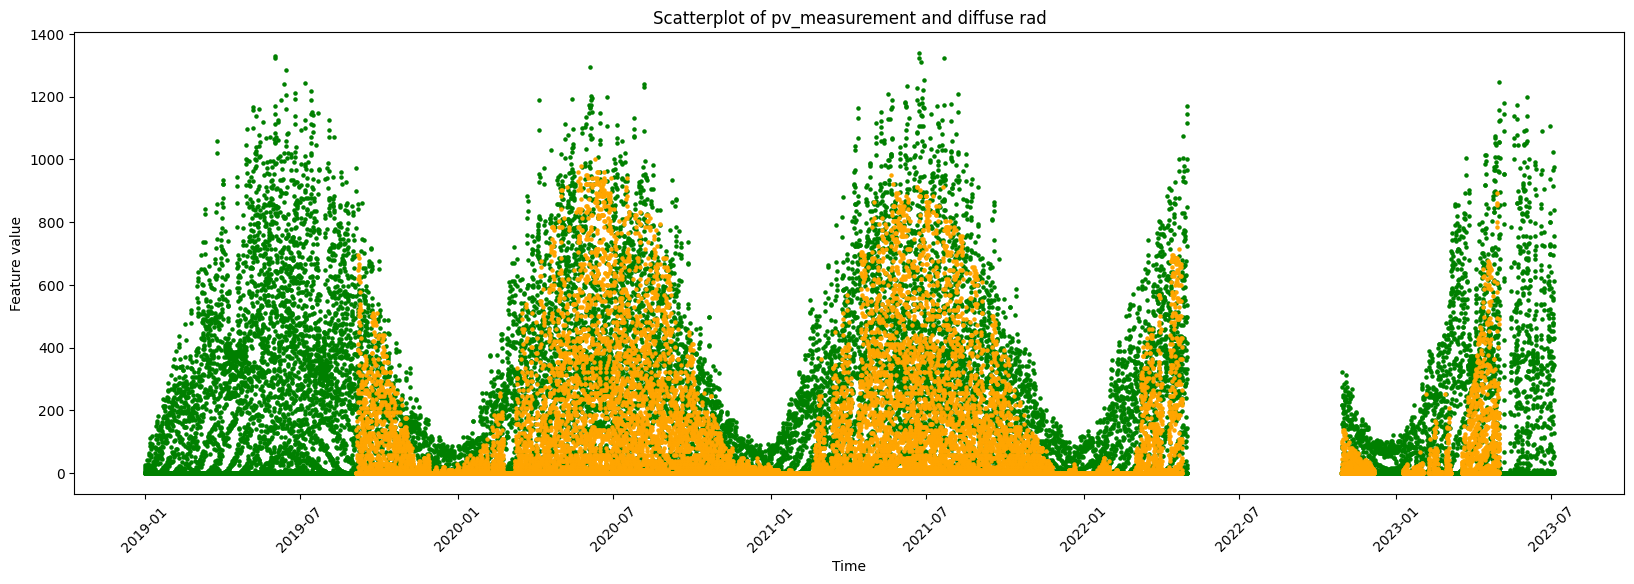

In [46]:
plt.figure(figsize=(20,6))
plt.scatter(X_train_estimated_c["date_forecast"], X_train_estimated_c["diffuse_rad:W"], s=5 ,color="green")
plt.scatter(X_train_observed_c["date_forecast"], X_train_observed_c["diffuse_rad:W"], s=5 ,color="green")
plt.scatter(y_c["time"], y_c["pv_measurement"], s=5, color="orange")
plt.title("Scatterplot of pv_measurement and diffuse rad")
plt.xlabel("Time")
plt.ylabel("Feature value")
plt.xticks(rotation=45)
plt.show()

### Plotting for fun

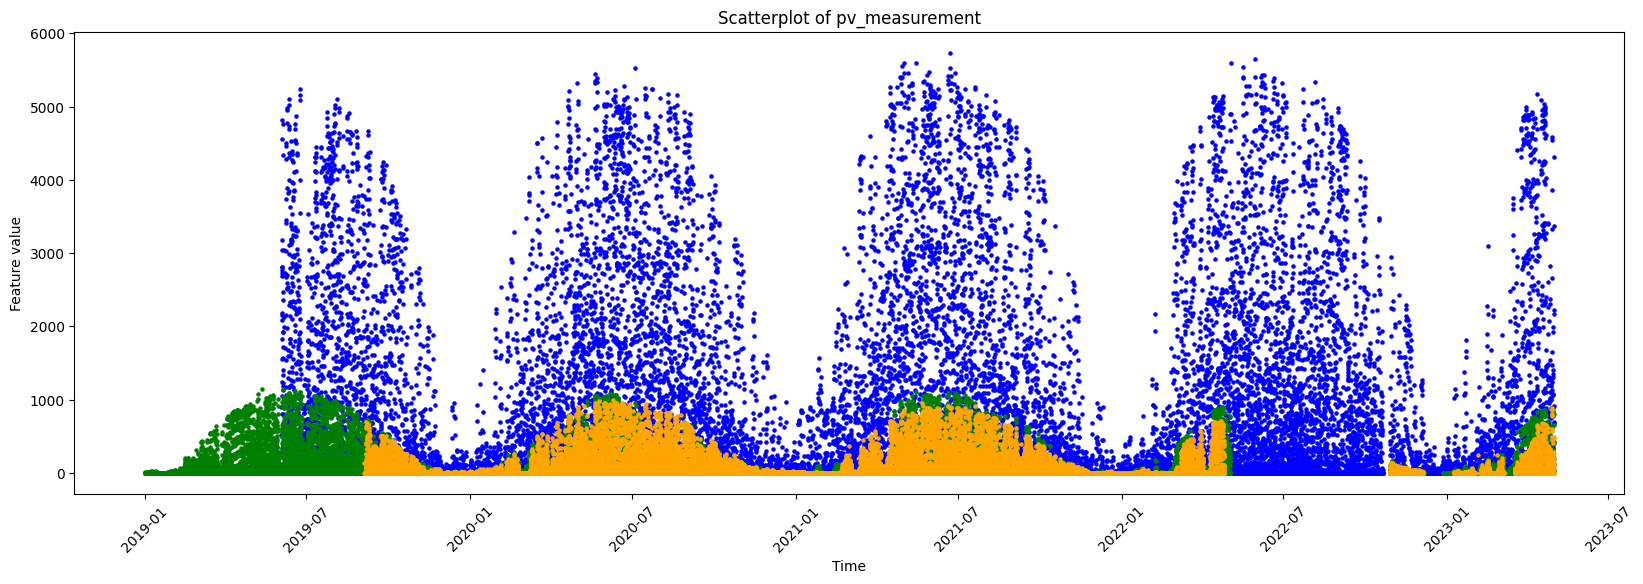

In [28]:
plt.figure(figsize=(20,6))
plt.scatter(y_a["time"], y_a["pv_measurement"], s=5, color="blue")
plt.scatter(y_b["time"], y_b["pv_measurement"], s=5 ,color="green")
plt.scatter(y_c["time"], y_c["pv_measurement"], s=5, color="orange")
plt.title("Scatterplot of pv_measurement")
plt.xlabel("Time")
plt.ylabel("Feature value")
plt.xticks(rotation=45)
plt.show()

Normalizing y_tables individually and plotting:

In [29]:
#A 
y_scaler_A = MinMaxScaler()
y_a["pv_measurement"] = y_scaler_A.fit_transform(y_a["pv_measurement"].values.reshape(-1,1))

#B
y_scaler_B = MinMaxScaler()
y_b["pv_measurement"] = y_scaler_B.fit_transform(y_b["pv_measurement"].values.reshape(-1,1))

#C
y_scaler_C = MinMaxScaler()
y_c["pv_measurement"] = y_scaler_C.fit_transform(y_c["pv_measurement"].values.reshape(-1,1))


Plotting again

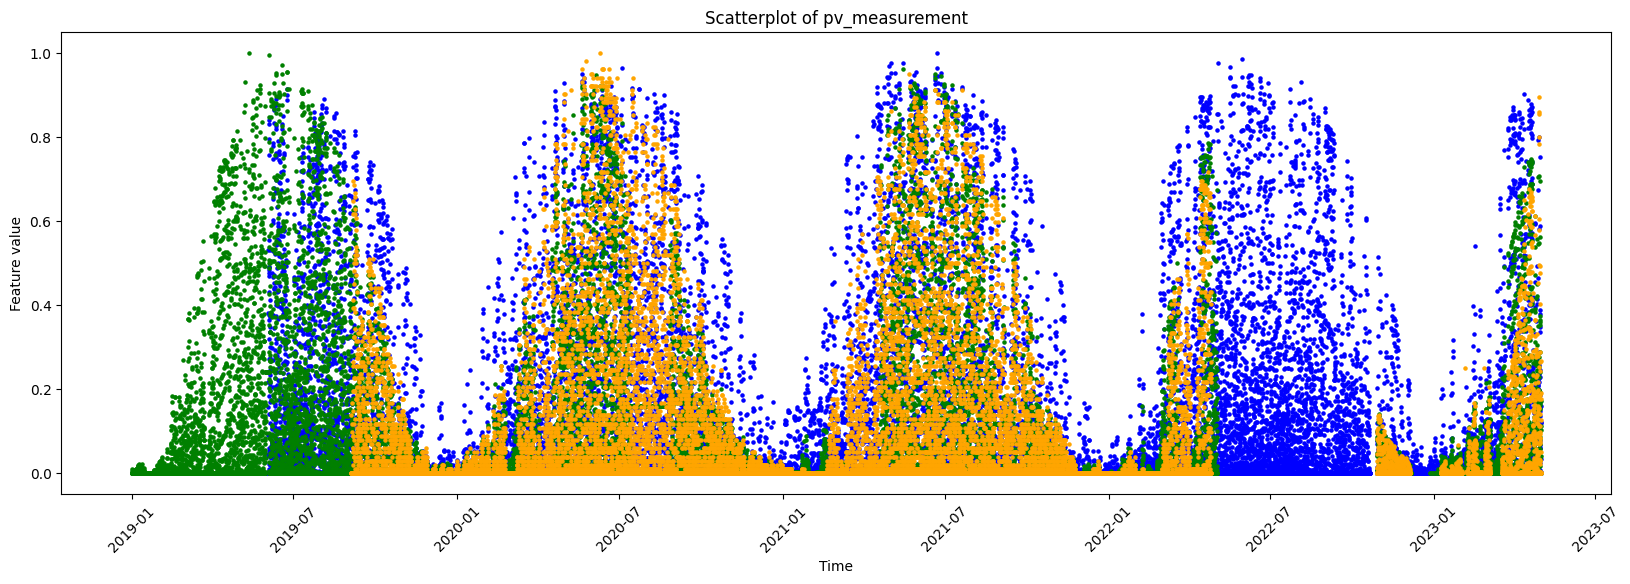

In [30]:
plt.figure(figsize=(20,6))
plt.scatter(y_a["time"], y_a["pv_measurement"], s=5, color="blue")
plt.scatter(y_b["time"], y_b["pv_measurement"], s=5 ,color="green")
plt.scatter(y_c["time"], y_c["pv_measurement"], s=5, color="orange")
plt.title("Scatterplot of pv_measurement")
plt.xlabel("Time")
plt.ylabel("Feature value")
plt.xticks(rotation=45)
plt.show()

#### Removing all NaN from y_targets
 - Removing all NaN from y_targets and their corresponding dates in the X_train sets, both observed and estimated
 

In [659]:
#Function that returns train_targets, observed and estimated sets left after filtering away NaN
def drop_nan_rows_in_target_and_train(y_df, observed_train_df, estimated_train_df):
    y_df = y_df.dropna(subset=['pv_measurement'])
    valid_dates = y_df['time']
    observed_train_df = observed_train_df[observed_train_df['date_forecast'].isin(valid_dates)]
    estimated_train_df = estimated_train_df[estimated_train_df['date_forecast'].isin(valid_dates)]
    return (y_df, observed_train_df, estimated_train_df)

In [660]:
#doing the NaN filtering
y_a, X_train_observed_a, X_train_estimated_a = drop_nan_rows_in_target_and_train(y_a, X_train_observed_a, X_train_estimated_a)
y_b, X_train_observed_b, X_train_estimated_b = drop_nan_rows_in_target_and_train(y_b, X_train_observed_b, X_train_estimated_b)
y_c, X_train_observed_c, X_train_estimated_c = drop_nan_rows_in_target_and_train(y_c, X_train_observed_c, X_train_estimated_c)

y_c.head()

,time,pv_measurement
5913,2019-09-04 08:00:00,137.2
5914,2019-09-04 09:00:00,0.0
5915,2019-09-04 10:00:00,0.0
5916,2019-09-04 11:00:00,0.0
5917,2019-09-04 12:00:00,0.0


In [661]:
X_train_observed_c.head()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,snow_melt_10min:mm,snow_water:kgm2,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,sun_azimuth:d_sin,sun_azimuth:d_cos
5912,2019-09-04 08:00:00,26.5,4.883,5283377.5,1684.900024,0.0,1112.800049,271.899994,9.320397e+05,1352.599976,...,0.0,0.0,103.019997,0.0,1134.900024,124.799995,198197.796875,5.0,3.039486,-2.582547
5913,2019-09-04 09:00:00,25.1,4.857,6726922.0,2032.500000,0.0,1109.699951,306.500000,1.041404e+06,1624.199951,...,0.0,0.0,120.817001,0.0,1139.199951,345.000000,209239.906250,6.0,2.200736,-3.324243
5914,2019-09-04 10:00:00,23.6,4.833,7747199.5,2247.500000,0.0,1106.600098,450.299988,1.362371e+06,1598.800049,...,0.0,0.0,132.110001,0.0,1143.599976,380.599976,215915.203125,8.0,1.117962,-3.825162
5915,2019-09-04 11:00:00,23.5,4.814,8254105.0,2312.100098,0.0,1106.599976,780.599976,2.215590e+06,1090.799927,...,0.0,0.0,135.548004,0.0,1147.699951,400.000000,218043.703125,7.8,-0.108947,-3.983159
5916,2019-09-04 12:00:00,24.6,4.807,8205280.0,2220.699951,0.0,1109.000000,973.500000,3.157120e+06,449.399994,...,0.0,0.2,130.675995,0.0,1150.000000,400.000000,217138.593750,6.1,-1.321110,-3.760065


#### Making time features

In [662]:
#Function that creates timefeatures based on the specified coloumn
def create_time_features_based_on_coloun(df, col):   
    df['hour'] = df[col].dt.hour
    df['dayofmonth'] = df[col].dt.day
    df['dayofweek'] = df[col].dt.dayofweek
    df['quarter'] = df[col].dt.quarter
    df['month'] = df[col].dt.month
    df['year'] = df[col].dt.year
    df['dayofyear'] = df[col].dt.dayofyear
    return df


In [663]:
# adding time features

#A
X_train_estimated_a = create_time_features_based_on_coloun(X_train_estimated_a, "date_forecast")
X_train_observed_a = create_time_features_based_on_coloun(X_train_observed_a, "date_forecast")
X_test_estimated_a = create_time_features_based_on_coloun(X_test_estimated_a, "date_forecast")

#B
X_train_estimated_b = create_time_features_based_on_coloun(X_train_estimated_b, "date_forecast")
X_train_observed_b = create_time_features_based_on_coloun(X_train_observed_b, "date_forecast")
X_test_estimated_b = create_time_features_based_on_coloun(X_test_estimated_b, "date_forecast")

#C
X_train_estimated_c = create_time_features_based_on_coloun(X_train_estimated_c, "date_forecast")
X_train_observed_c = create_time_features_based_on_coloun(X_train_observed_c, "date_forecast")
X_test_estimated_c = create_time_features_based_on_coloun(X_test_estimated_c, "date_forecast")



Just showing the shapes to se if i havent f'ed up

In [664]:
# printing shapes
print("A")
print(X_train_estimated_a.shape)
print(X_train_observed_a.shape)
print(X_train_estimated_a.shape[0]+X_train_observed_a.shape[0])
print(y_a.shape)

print("B")
print(X_train_estimated_b.shape)
print(X_train_observed_b.shape)
print(X_train_estimated_b.shape[0]+X_train_observed_b.shape[0])  ## this one seems to be of by 1??????
print(y_b.shape)

print("C")
print(X_train_estimated_c.shape)
print(X_train_observed_c.shape)
print(X_train_estimated_c.shape[0]+X_train_observed_c.shape[0])
print(y_c.shape)

A
(4418, 43)
(29667, 43)
34085
(34085, 2)
B
(3625, 43)
(29218, 43)
32843
(32844, 2)
C
(2954, 43)
(23141, 43)
26095
(26095, 2)


We can see that for B there is actually on row more in the target set for some reason, finding that row and deleting it:

In [665]:
## Finding the row in y_b that does not have a match

# renaming
date_times_estimated = X_train_estimated_b['date_forecast']
date_times_observed = X_train_observed_b['date_forecast']
result_df = y_b[~y_b['time'].isin(date_times_estimated) & ~y_b['time'].isin(date_times_observed)]
print(result_df)


                 time  pv_measurement
0 2018-12-31 23:00:00             0.0


Okey so let's remove that row and verify that everything is correct:

In [666]:
# removing row
y_b = y_b[~y_b['time'].isin(result_df['time'])]

# checking that the numbers add up again
print("B")
print(X_train_estimated_b.shape)
print(X_train_observed_b.shape)
print(X_train_estimated_b.shape[0]+X_train_observed_b.shape[0])
print(y_b.shape)


B
(3625, 43)
(29218, 43)
32843
(32843, 2)


#### Removing repeated indices


#### Dividing the sets into training and validation

In [667]:
# first renaming the date_forecast columns to time  (DOES NOT WORK)
for df in list_of_all_estimated_and_observed_sets:               
    df.rename(columns={'date_forecast': 'time'}, inplace=True)

#maybe we can drop it here already actually
X_train_observed_a.head()



,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,wind_speed_10m:ms,sun_azimuth:d_sin,sun_azimuth:d_cos,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear
0,2019-06-02 22:00:00,30.799999,4.913,0.000000,0.000000,0.0,1121.199951,0.000000,0.000000,0.0,...,14.4,-0.827235,3.904145,22,2,6,2,6,2019,153
1,2019-06-02 23:00:00,30.799999,4.894,0.000000,0.000000,0.0,1121.199951,0.000000,0.000000,0.0,...,13.4,0.137934,3.988335,23,2,6,2,6,2019,153
2,2019-06-03 00:00:00,31.500000,4.879,0.000000,0.000000,0.0,1122.599976,0.000000,0.000000,0.0,...,12.2,1.028531,3.856086,0,3,0,2,6,2019,154
3,2019-06-03 01:00:00,33.700001,4.872,834.599976,3.000000,0.0,1126.699951,1.200000,2107.100098,0.0,...,10.9,1.912442,3.503262,1,3,0,2,6,2019,154
4,2019-06-03 02:00:00,35.799999,4.872,129872.601562,92.400002,0.0,1130.000000,47.900002,88275.796875,0.6,...,10.2,2.670854,2.966543,2,3,0,2,6,2019,154


Training data = first 75% of observed + first 75% of estimated
Validation data = last 25% of observed + last 25% of estimated

In [668]:



# Making training and validation data for A
percent_observed_train_a = 1
percent_estimated_train_a = 1

split_index_obs_a = int(len(X_train_observed_a)*percent_observed_train_a)
X_train_observed_a_first_75 = X_train_observed_a[:split_index_obs_a]
X_train_observed_a_last_25 = X_train_observed_a[split_index_obs_a:]

split_index_est_a = int(len(X_train_estimated_a)*percent_estimated_train_a)
X_train_estimated_a_first_75 = X_train_estimated_a[:split_index_est_a]
X_train_estimated_a_last_25 = X_train_estimated_a[split_index_est_a:]

X_train_a = pd.concat([X_train_observed_a_first_75, X_train_estimated_a_first_75])
y_train_a = y_a[y_a["time"].isin(X_train_a['date_forecast'])]
print(X_train_a.shape, y_train_a.shape)

X_validate_a = pd.concat([X_train_observed_a_last_25, X_train_estimated_a_last_25])
y_validate_a = y_a[y_a["time"].isin(X_validate_a['date_forecast'])]


# making training and validation for B
percent_observed_train_b = 1
percent_estimated_train_b = 1

split_index_obs_b = int(len(X_train_observed_b)*percent_observed_train_b)
X_train_observed_b_first_75 = X_train_observed_b[:split_index_obs_b]
X_train_observed_b_last_25 = X_train_observed_b[split_index_obs_b:]


split_index_est_b = int(len(X_train_estimated_b)*percent_estimated_train_b)
X_train_estimated_b_first_75 = X_train_estimated_b[:split_index_est_b]
X_train_estimated_b_last_25 = X_train_estimated_b[split_index_est_b:]

X_train_b = pd.concat([X_train_observed_b_first_75, X_train_estimated_b_first_75])
y_train_b = y_b[y_b["time"].isin(X_train_b['date_forecast'])]
print(X_train_b.shape, y_train_b.shape)

X_validate_b = pd.concat([X_train_observed_b_last_25, X_train_estimated_b_last_25])
y_validate_b = y_b[y_b["time"].isin(X_validate_b['date_forecast'])]

# making training and validation for C
percent_observed_train_c = 1
percent_estimated_train_c = 1

split_index_obs_c = int(len(X_train_observed_c)*percent_observed_train_c)
X_train_observed_c_first_75 = X_train_observed_c[:split_index_obs_c]
X_train_observed_c_last_25 = X_train_observed_c[split_index_obs_c:]

split_index_est_c = int(len(X_train_estimated_c)*percent_estimated_train_c)
X_train_estimated_c_first_75 = X_train_estimated_c[:split_index_est_c]
X_train_estimated_c_last_25 = X_train_estimated_c[split_index_est_c:]

X_train_c = pd.concat([X_train_observed_c_first_75, X_train_estimated_c_first_75])
y_train_c = y_c[y_c["time"].isin(X_train_c['date_forecast'])]
print(X_train_c.shape, y_train_c.shape)

X_validate_c = pd.concat([X_train_observed_c_last_25, X_train_estimated_c_last_25])
y_validate_c = y_c[y_c["time"].isin(X_validate_c['date_forecast'])]


(34085, 43) (34085, 2)
(32843, 43) (32843, 2)
(26095, 43) (26095, 2)


#### Removing repeated indexes here, think this might be the wrong place to do it, should probably to it for the concat BUT hEY

In [669]:

def find_repeated_indexes(df, column_name, repeat_count=12):
    """
    Find and return the indexes of rows with a specified number of repeated values in a given column.

    Parameters:
    - df: DataFrame to search for repeated rows.
    - column_name: Name of the column to check for repeated values.
    - repeat_count: Number of repeated values required to consider a row as a match.

    Returns:
    - List of indexes for rows with the specified number of repeated values in the given column.
    """
    df = df.reset_index()
    repeated_indexes = []
    temp_repeated_indexes = []
    current_value = None
    count = 0

    for index, row in df.iterrows():

        value = row[column_name]

        if value == current_value:
            count += 1
            temp_repeated_indexes.append(index)
        else:
            current_value = value
            if count <= repeat_count:
                temp_repeated_indexes = []
                count = 1
            else:
                for i in temp_repeated_indexes:
                    if i not in repeated_indexes:
                        repeated_indexes.append(i)
                temp_repeated_indexes = []
                count = 1
            

    return repeated_indexes



In [670]:
#removing repeated indexes

#A
print(X_train_a.shape, y_train_a.shape)
repeated_indices = find_repeated_indexes(y_train_a,"pv_measurement", 24)
y_train_a = y_train_a.reset_index()
y_train_a = y_train_a.drop(repeated_indices)
X_train_a = X_train_a[X_train_a["date_forecast"].isin(y_train_a["time"])]
print(X_train_a.shape, y_train_a.shape)

repeated_indices = find_repeated_indexes(y_validate_a,"pv_measurement",22)
y_validate_a = y_validate_a.reset_index()
y_validate_a = y_validate_a.drop(repeated_indices)
X_validate_a = X_validate_a[X_validate_a["date_forecast"].isin(y_validate_a["time"])]

y_train_a.reset_index(drop=True, inplace=True)
X_train_a.reset_index(drop=True, inplace=True)
y_validate_a.reset_index(drop=True, inplace=True)
X_validate_a.reset_index(drop=True, inplace=True)



(34085, 43) (34085, 2)


(34043, 43) (34043, 3)


In [671]:
#B  -  works reeaaaly well for B
print(X_train_b.shape, y_train_b.shape)
repeated_indices = find_repeated_indexes(y_train_b,"pv_measurement", 24)
y_train_b = y_train_b.reset_index()
y_train_b = y_train_b.drop(repeated_indices)
X_train_b = X_train_b[X_train_b["date_forecast"].isin(y_train_b["time"])]
print(X_train_b.shape, y_train_b.shape)

repeated_indices = find_repeated_indexes(y_validate_b,"pv_measurement",24)
y_validate_b = y_validate_b.reset_index()
y_validate_b = y_validate_b.drop(repeated_indices)
X_validate_b = X_validate_b[X_validate_b["date_forecast"].isin(y_validate_b["time"])]

y_train_b.reset_index(drop=True, inplace=True)
X_train_b.reset_index(drop=True, inplace=True)
y_validate_b.reset_index(drop=True, inplace=True)
X_validate_b.reset_index(drop=True, inplace=True)

(32843, 43) (32843, 2)
(25954, 43) (25954, 3)


In [672]:
#C
print(X_train_c.shape, y_train_c.shape)
repeated_indices = find_repeated_indexes(y_train_c,"pv_measurement", 24)
y_train_c = y_train_c.reset_index()
y_train_c = y_train_c.drop(repeated_indices)
X_train_c = X_train_c[X_train_c["date_forecast"].isin(y_train_c["time"])]
print(X_train_c.shape, y_train_c.shape)

repeated_indices = find_repeated_indexes(y_validate_c,"pv_measurement",24)
y_validate_c = y_validate_c.reset_index()
y_validate_c = y_validate_c.drop(repeated_indices)
X_validate_c = X_validate_c[X_validate_c["date_forecast"].isin(y_validate_c["time"])]

y_train_c.reset_index(drop=True, inplace=True)
X_train_c.reset_index(drop=True, inplace=True)
y_validate_c.reset_index(drop=True, inplace=True)
X_validate_c.reset_index(drop=True, inplace=True)

(26095, 43) (26095, 2)
(21169, 43) (21169, 3)


Removing time feature

In [673]:
X_train_a.drop("date_forecast", axis=1, inplace=True)
y_train_a.drop("time", axis=1, inplace=True)
X_validate_a.drop("date_forecast", axis=1, inplace=True)
y_validate_a.drop("time", axis=1, inplace=True)

X_train_b.drop("date_forecast", axis=1, inplace=True)
y_train_b.drop("time", axis=1, inplace=True)
X_validate_b.drop("date_forecast", axis=1, inplace=True)
y_validate_b.drop("time", axis=1, inplace=True)

X_train_c.drop("date_forecast", axis=1, inplace=True)
y_train_c.drop("time", axis=1, inplace=True)
X_validate_c.drop("date_forecast", axis=1, inplace=True)
y_validate_c.drop("time", axis=1, inplace=True)


Adding location features to the sets before merge

In [674]:
X_train_a["location"] =  "A" 
y_train_a["location"] = "A"
X_validate_a["location"] = "A"
y_validate_a["location"] = "A"

X_train_b["location"] = "B"
y_train_b["location"] = "B"
X_validate_b["location"] = "B"
y_validate_b["location"] = "B"

X_train_c["location"] = "C"
y_train_c["location"] = "C"
X_validate_c["location"] = "C"
y_validate_c["location"] = "C"


Merging tranining data:


In [675]:
X_train = pd.concat([X_train_a, X_train_b, X_train_c])
y_train = pd.concat([y_train_a, y_train_b, y_train_c])

X_validate = pd.concat([X_validate_a, X_validate_b, X_validate_c])
y_validate = pd.concat([y_validate_a, y_validate_b, y_validate_c])

print(X_train.shape)
print(y_train.shape)

(81166, 43)
(81166, 3)


One-hot encoding

In [676]:
# one hot encoding and dropping location feature   some fuckery here
# one_hot = pd.get_dummies(X_train["location"]).astype(int)
# X_train = X_train.drop("location", axis=1)
# X_train = pd.merge(X_train, one_hot, left_index=True, right_index=True)


# one_hot = pd.get_dummies(X_validate["location"]).astype(int)
# X_validate = pd.merge(X_validate, one_hot, left_index=True, right_index=True)


# print(X_train.shape)
# print(y_train.shape)

Fixing test set

In [677]:
# load valid dates function
import os


dir_path = os.getcwd()
def load_valid_dates():
    
    test = pd.read_csv(f"{dir_path}/../data/test.csv")

    return test["time"].unique().tolist()

In [678]:
#adding location feature

X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"

# concatting:
X_test = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c])
# filtering out invalid dates:
X_test = X_test[X_test["date_forecast"].isin(load_valid_dates())]
# removing forecast coloum
X_test = X_test.drop("date_forecast", axis=1)

One-hot encoding:


In [679]:
X_train = X_train.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_train["location"]).astype(int)
X_train = X_train.drop("location", axis=1)
X_train = pd.merge(X_train, one_hot, left_index=True, right_index=True)

X_validate = X_validate.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_validate["location"]).astype(int)
X_validate = X_validate.drop("location", axis=1)
X_validate = pd.merge(X_validate, one_hot, left_index=True, right_index=True)

X_test = X_test.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_test["location"]).astype(int)
X_test = X_test.drop("location", axis=1)
X_test = pd.merge(X_test, one_hot, left_index=True, right_index=True)

X_test
# one_hot

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear,A,B,C
0,17.300001,5.147,0.000000e+00,0.000000,0.0,1086.600098,0.000000,0.000000,0.000000,0.000000,...,0,1,0,2,5,2023,121,1,0,0
1,17.100000,5.144,0.000000e+00,0.000000,0.0,1085.800049,0.000000,0.000000,0.000000,0.000000,...,1,1,0,2,5,2023,121,1,0,0
2,16.599998,5.135,0.000000e+00,0.000000,0.0,1084.199951,0.000000,0.000000,0.000000,0.000000,...,2,1,0,2,5,2023,121,1,0,0
3,16.100000,5.128,4.049770e+04,46.700001,0.0,1082.599976,37.500000,67380.906250,8.400000,15061.400391,...,3,1,0,2,5,2023,121,1,0,0
4,15.600000,5.124,5.669944e+05,307.500000,0.0,1081.500000,189.600006,408838.812500,101.800003,198284.796875,...,4,1,0,2,5,2023,121,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,33.599998,4.787,1.903926e+06,339.100006,0.0,1126.800049,128.800003,650270.125000,53.800003,212259.687500,...,19,3,0,3,7,2023,184,0,0,1
2156,34.400002,4.800,7.330454e+05,98.199997,0.0,1128.099976,55.500000,331501.406250,9.600000,114095.203125,...,20,3,0,3,7,2023,184,0,0,1
2157,35.500000,4.814,1.473243e+05,4.900000,0.0,1129.400024,5.000000,108841.000000,0.000000,17289.900391,...,21,3,0,3,7,2023,184,0,0,1
2158,36.000000,4.826,1.378300e+03,0.000000,0.0,1130.400024,0.000000,8968.599609,0.000000,0.000000,...,22,3,0,3,7,2023,184,0,0,1


Normalizing data

In [680]:
columns_to_exclude = ["A", "B", "C", "dew_or_rime:idx", "is_day:idx", "_in_shadow:idx"]

columns_to_normalize = [col for col in X_train.columns if col not in columns_to_exclude]

#Mean - std normalization

# X_train_mean = X_train.mean()
# X_train_std = X_train.std()

# X_train = (X_train - X_train_mean) / X_train_std
# X_validate = (X_validate- X_train_mean) / X_train_std
# X_test =  (X_test - X_train_mean) / X_train_std


#Min-max
# Calculate min and max values for scaling
X_min = X_train[columns_to_normalize].min()
X_max = X_train[columns_to_normalize].max()

# Apply min-max scaling to the columns to be normalized
X_train[columns_to_normalize] = (X_train[columns_to_normalize] - X_min) / (X_max - X_min)
X_validate[columns_to_normalize] = (X_validate[columns_to_normalize] - X_min) / (X_max - X_min)
X_test[columns_to_normalize] = (X_test[columns_to_normalize] - X_min) / (X_max - X_min)


Normalizing Y

In [681]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
print(y_train)


y_train["pv_measurement"] = y_scaler.fit_transform(y_train["pv_measurement"].values.reshape(-1,1))

print(y_train)



       index  pv_measurement location
0          0            0.00        A
1          1            0.00        A
2          2            0.00        A
3          3            0.00        A
4          4           19.36        A
...      ...             ...      ...
21164  32150           50.96        C
21165  32151            2.94        C
21166  32152            0.00        C
21167  32153           -0.00        C
21168  32154           -0.00        C

[81166 rows x 3 columns]
       index  pv_measurement location
0          0        0.000000        A
1          1        0.000000        A
2          2        0.000000        A
3          3        0.000000        A
4          4        0.003377        A
...      ...             ...      ...
21164  32150        0.008888        C
21165  32151        0.000513        C
21166  32152        0.000000        C
21167  32153        0.000000        C
21168  32154        0.000000        C

[81166 rows x 3 columns]


In [682]:
# model = xgb.XGBRegressor(
#     max_depth=7,
#     colsample_bytree=0.8,
#     eta=0.1,
#     n_estimators=90,
#     reg_alpha=0.01,
#     reg_lambda=0.01,
#     enable_categorical=True
# )

# model.fit(X_train, y_train["pv_measurement"])

# X_validate_a_loc = X_validate[X_validate_a["location"]=="A"]
# X_validate_a_loc = X_validate_a_loc.drop("location", axis=1)

# prediction = model.predict(X_validate)

# prediction_a = model.predict(X_validate_a)
# prediction_b = model.predict(X_validate_b)
# prediction_c = model.predict(X_validate_c)

In [683]:
# print(
#     "MAE: ",
#     round(
#         mean_absolute_error(
#             y_true=y_validate["pv_measurement"],
#             y_pred=prediction,
#         ),
#         3,
#     ),
# )

In [684]:
# predicting:
# predict = model.predict(X_test)
# print(predict.head())
# predict = y_scaler.inverse_transform(predict.reshape(-1, 1))
# print(predict.head())

# resultframe = pd.DataFrame(columns = ["id", "prediction"])
# resultframe["prediction"] = predict
# print(resultframe.shape)
# resultframe["id"] = range(len(resultframe))
# resultframe.head()
# # making the csv
# # final = prediction.reset_index().reset_index().rename(columns={"level_0": "id", "y": "prediction"})[["id", "prediction"]]

# resultframe.to_csv("submission_super_all_the_guys_6.csv", index=False)

In [685]:
X_test.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear,A,B,C
0,0.249280,0.902191,0.000000,0.000000,0.0,0.925160,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
1,0.246398,0.901665,0.000000,0.000000,0.0,0.924479,0.000000,0.000000,0.000000,0.000000,...,0.043478,0.0,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
2,0.239193,0.900088,0.000000,0.000000,0.0,0.923116,0.000000,0.000000,0.000000,0.000000,...,0.086957,0.0,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
3,0.231988,0.898861,0.003385,0.013971,0.0,0.921754,0.028006,0.014057,0.003073,0.001542,...,0.130435,0.0,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
4,0.224784,0.898160,0.047398,0.091994,0.0,0.920817,0.141598,0.085295,0.037240,0.020301,...,0.173913,0.0,0.0,0.333333,0.363636,1.0,0.328767,1,0,0


## Making the h20 models

In [687]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

X_train = X_train.reset_index().drop(columns="index")
y_train = y_train.reset_index().drop(columns="index")
new_train = pd.merge(X_train, y_train["pv_measurement"], left_index=True, right_index=True)

X_validate = X_validate.reset_index().drop(columns="index")
y_validate = y_validate.reset_index().drop(columns="index")
new_validate = pd.merge(X_validate, y_validate["pv_measurement"], left_index=True, right_index=True)

h2o_train= h2o.H2OFrame(new_train)
h2o_validate= h2o.H2OFrame(new_validate)
h2o_test = h2o.H2OFrame(X_test)

aml = H2OAutoML(max_models=20, seed=1, stopping_metric="MAE", sort_metric="MAE", stopping_tolerance=0.01)
# aml.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train, validation_frame=h2o_validate)
aml.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train)
lb = aml.leaderboard



Checking whether there is an H2O instance running at http://localhost:54321.

 connected.


H2O_cluster_uptime:,23 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_siver_z3wyw2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.468 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
15:00:02.379: Stopping tolerance set by the user is < 70% of the recommended default of 0.003510046970709824, so models may take a long time to converge or may not converge at all.
15:00:02.396: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


In [688]:
lb.head(rows=lb.nrows)

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20231013_150002,0.014048,0.0418226,0.00174913,0.0308816,0.00174913
GBM_grid_1_AutoML_1_20231013_150002_model_5,0.0141281,0.0427161,0.00182467,0.0315176,0.00182467
StackedEnsemble_BestOfFamily_1_AutoML_1_20231013_150002,0.014371,0.042676,0.00182124,0.0314934,0.00182124
GBM_4_AutoML_1_20231013_150002,0.014417,0.0428197,0.00183353,0.0316697,0.00183353
GBM_3_AutoML_1_20231013_150002,0.0149521,0.0437129,0.00191081,0.0323701,0.00191081
GBM_2_AutoML_1_20231013_150002,0.015389,0.0441794,0.00195182,0.0327929,0.00195182
GBM_1_AutoML_1_20231013_150002,0.0156022,0.0455307,0.00207304,0.0337233,0.00207304
DRF_1_AutoML_1_20231013_150002,0.0157895,0.0464496,0.00215756,0.0343897,0.00215756
GBM_grid_1_AutoML_1_20231013_150002_model_4,0.0158429,0.0440226,0.00193799,0.0326454,0.00193799
GBM_5_AutoML_1_20231013_150002,0.0160183,0.0457813,0.00209593,0.0340037,0.00209593


Predict with the best model

In [689]:
prediction_best_model = aml.leader.predict(h2o_test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


Make predictions with the best 3 models: 

In [ ]:
second_model_id = lb[1, "model_id"]

model = h2o.get_model(second_model_id)

# Make predictions using the second model on the test dataset
second_model_predictions = model.predict(h2o_test)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [ ]:
second_model_predictions = second_model_predictions.as_data_frame()

Convert the best model to valid format:


In [690]:
leaderboard_df = lb.as_data_frame() 
prediction_df = prediction_best_model.as_data_frame()


Renormalizing

In [691]:
prediction_best__df_scaled = y_scaler.inverse_transform(prediction_df)
print(prediction_best__df_scaled)
prediction_best__df_scaled = pd.DataFrame(prediction_best__df_scaled)
print(prediction_best__df_scaled)

[[-6.04932974]
 [-5.91191766]
 [-5.70656875]
 ...
 [ 1.92092482]
 [-7.40723668]
 [-5.74793965]]
               0
0      -6.049330
1      -5.911918
2      -5.706569
3      70.854433
4     397.569878
...          ...
2155   48.454956
2156   28.572984
2157    1.920925
2158   -7.407237
2159   -5.747940

[2160 rows x 1 columns]


Doing the same for the top 3 models:

In [ ]:
prediction_second_best_scaled = y_scaler.inverse_transform(second_model_predictions)
print(prediction_second_best_scaled)
prediction_second_best_scaled_df = pd.DataFrame(prediction_second_best_scaled)
print(prediction_second_best_scaled_df)

[[-8.17388162]
 [-8.19603506]
 [-7.91539723]
 ...
 [-0.56578328]
 [-9.40780357]
 [-6.42414963]]
               0
0      -8.173882
1      -8.196035
2      -7.915397
3      70.044301
4     399.795769
...          ...
2155   46.563659
2156   27.804607
2157   -0.565783
2158   -9.407804
2159   -6.424150

[2160 rows x 1 columns]


Shutting down the cluster

In [692]:
h2o.cluster().shutdown()

H2O session _sid_86ee closed.


Making a submission for the best model

In [693]:
resultframe = pd.DataFrame(columns = ["id", "prediction"])
resultframe["prediction"] = prediction_best__df_scaled
resultframe['prediction'] = np.where(resultframe['prediction'] < 0, 0, resultframe['prediction'])
resultframe["id"] = range(len(resultframe))
resultframe.head()

,id,prediction
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,70.854433
4,4,397.569878


Actual submission

In [ ]:
resultframe.to_csv("sumbission_all_the_boys_5_001_tolerance.csv", index=False)

Making a submission for second best model:

In [ ]:
# resultframe2 = pd.DataFrame(columns = ["id", "prediction"])
# resultframe2["prediction"] = prediction_second_best_scaled_df
# resultframe2['prediction'] = np.where(resultframe2['prediction'] < 0, 0, resultframe2['prediction'])
# resultframe2["id"] = range(len(resultframe2))
# resultframe2.head()

,id,prediction
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,70.044301
4,4,399.795769


In [ ]:
# resultframe2.to_csv("sumbission_all_the_boys_4_second_best.csv", index=False)